# Compressed Sensing

<font color='green'> This practical session serves as a gentle introduction to compressed sensing - a signal processing/statistical technique for recovering a sparse signal from an underdetermined system of linear equations. Our main objectives are the following:
</font>
- <font color='green'>introducing the basis pursuit linear program - a convex relaxation to the combinatorial optimization problem that we want to solve;</font>
- <font color='green'>understanding the interplay between the nullspace of the design matrix and the geometry of $\ell_{1}$ norm that allows for sparse signal recovery via the basis pursuit program;
- <font color='green'>introducing the restricted isometry property - a sufficient condition that ensures the success of the basis pursuit program;
- <font color='green'>demonstrating (one of many possible) practical applications of the presented theory — showing how to utilize compressed sensing ideas to design single-pixel cameras.</font>


The setup of this practical session can be described as follows. We want to recover some signal vector $x^{\star} \in \mathbb{R}^{d}$ given access to $n \ll d$ linear measurements $y_{i} = \langle x_{i}, w^{\star} \rangle$. In matrix-vector notation, the observations $y_{i}$ follow the model
$$
  y = X w^{\star}, \tag{1}
$$
where $X \in \mathbb{R}^{n \times d}$.
The key difficulty in recovering $w^{\star}$ given $(x_{i}, y_{i})_{i=1}^{n}$ stems from the fact that the above linear system is *underdetermined*, and so there exist infinitely many $w$ such that $Xw = y$. Indeed, since $d > n$, the nullspace of $X$ is of rank at least $n - d \geq 1$, and hence it contains an infinite number of vectors. A sum of any such vector with the target vector $w^{\star}$ yields a candidate solution to the above linear system.

However, if the signal vector $w^{\star}$ is known to be $k$-sparse
(with $k \ll n$), then the above linear system can be solved *efficiently* for certain design matrices $X$. Understanding sufficient conditions for the solvability of underdetermined linear systems as well as some real-world implications are the primary subjects of this practical session.

We remark that in this practical session, we work under idealized conditions.
In particular, we assume that the linear measurements $y_{i}$ contain no noise and that the target signal vector $w^{\star}$ is exactly sparse. Various extensions can be obtained for noisy observations as well as approximately sparse target vectors; the interested reader will find pointers to the existing literature at the end of this notebook.

## Sparse Recovery via Linear Programming

Let $\|w\|_{0}$ denote the "$\ell_{0}$ norm" of $w$, equal to the number of non-zero coordinates of $w$. Given the knowledge that the true signal vector $w^{\star}$ is sparse, arguably the most natural approach to recovering $w^{\star}$ from the underdetermined linear system $(1)$ is to look for a vector $w$ with fewest non-zero entries that is consistent with the observations, that is, a solution to the following program:
$$
  \min \|w\|_{0} \quad\text{subject to}\quad Xw = y
$$
The combinatorial nature of the above problem, however, presents computational challenges: the naive approach of enumerating all possible subsets of coordinates and trying to solve the above linear system using the selected variables would require exponential running time in
the sparsity level $k$ and thus, is infeasible in practice.

To circumvent computational issues, we will instead consider
replacing the "$\ell_{0}$ norm" with an $\ell_{q}$ norm for the smallest $q > 0$ that yields a convex program. The smallest such $q$ is given by the choice $q=1$ and thus we will aim to solve the following program, called *basis pursuit*:
$$
  \min \|w\|_{1}\quad\text{subject to}\quad Xw = y.
  \tag{2}
$$

<font color='green'>**While the above optimization problem is readily seen to be convex, it can be
rephrased as a [linear program](https://en.wikipedia.org/wiki/Linear_programming)**</font>.
Such problems, written in a standardized form, can be expressed as
\begin{align*}
  &\min_{x \in \mathbb{R}^{d}} \langle c, x\rangle \\
  &\text{subject to}\quad
  Ax = b\quad\text{and}\quad
  Gx \preccurlyeq h,
\end{align*}
where the vectors $c,b,h$ and the matrices $A, G$ are arbitrary problem parameters, and the notation $\preccurlyeq$ denotes a componentwise inequality. 
Linear programs can be solved in [weakly polynomial](https://en.wikipedia.org/wiki/Linear_programming#Open_problems_and_recent_work) time by general-purpose solvers.

### Exercise 1

Show that the convex program $(2)$ can be expressed as a linear program.
Use the [cvxopt](https://cvxopt.org/) package (imported in the below cell) to implement a solver for $(2)$ by completing the missing code two cells below. For the cvxopt package documentation concerning linear programs see http://cvxopt.org/userguide/coneprog.html#linear-programming.

In [20]:
import numpy as np
import cvxopt
from matplotlib import pyplot as plt

In [21]:
def compute_minimum_l1_norm_solution(X, y):
  """ :X: An n \times d matrix.
      :y: An n dimensional array such that y = Xw* for some k-sparse vector w*.
      :returns: A vector w that solves the l1 minimization program (2).
  """
  ##############################################################################
  # Exercise 1. Fill in the implementation of this function by using
  # cvxopt.solvers.lp function.
  n = X.shape[0]
  d = X.shape[1]
  # Set up the linear programming variables. 
  c = np.concatenate((np.zeros(d), np.ones(d))).reshape(-1, 1)
  A = np.concatenate((X, np.zeros((n, d))), axis=1)
  h = np.zeros(2 * d).reshape(-1, 1)
  # We will use sparse matrix representation of G.
  # Note that cvxopt takes lists columns as arguments rather than lists of rows
  # as done by numpy.
  Id = cvxopt.spmatrix(1.0, range(d), range(d))
  G = cvxopt.sparse([[Id, -Id], [-Id, -Id]])
  # Convert c,A,b and h to cvxopt matrices.
  c = cvxopt.matrix(c)
  A = cvxopt.matrix(A)
  b = cvxopt.matrix(y.reshape((n,1)))
  h = cvxopt.matrix(h)
  # Solve the linear program.
  solution = cvxopt.solvers.lp(c, G, h, A, b)
  w = np.array(solution['x'][:d]).reshape(-1,1)
  return w
  ##############################################################################

# The below code is designed to test your implementation of the above function.
n = 100
d = 1000
k = 10
w_star = np.zeros((d,1))
w_star[:k,0] = 1
# We will see why the below choice of the measurements matrix X works in
# Exercise 2.
X = n**(-1/2) * np.random.binomial(n=1, p=0.5, size=(n,d))*2 - 1.0
y = X @ w_star
w = compute_minimum_l1_norm_solution(X, y)
# The below should print approximately 0.
print("||w - w*||_{2}^{2} =", np.sum((w.reshape(d, 1) - w_star)**2))

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  5e+01  1e-16  1e+00
 1:  1.6681e+00  1.6676e+00  1e+02  5e+00  2e-16  1e-01
 2:  8.1252e+00  8.1229e+00  7e+01  3e+00  6e-16  6e-02
 3:  8.8638e+00  8.8575e+00  5e+01  2e+00  9e-16  4e-02
 4:  9.3644e+00  9.3581e+00  2e+01  8e-01  9e-16  1e-02
 5:  9.9854e+00  9.9852e+00  8e-01  3e-02  6e-16  4e-04
 6:  9.9999e+00  9.9999e+00  8e-03  3e-04  7e-16  4e-06
 7:  1.0000e+01  1.0000e+01  8e-05  3e-06  7e-16  4e-08
Terminated (singular KKT matrix).
||w - w*||_{2}^{2} = 2.6129493479741314e-12


#### Solution

We can reformulate $(2)$ via the following equivalent linear program, by intruducing an additional variable $t \in \mathbb{R}^{d}$:
\begin{align*}
  &\min_{w,t \in \mathbb{R}^{d}} \sum_{i=1}^{d} t_{i} \\
  &\text{subject to}\quad
  Xw = y\quad\text{and}\quad
  w_{i} \leq t_{i},\, w_{i} \geq -t_{i}\text{ for }i = 1,\dots d.
\end{align*}
The above formulation can be passed to the cvxopt package as follows:
```
  n = X.shape[0]
  d = X.shape[1]
  # Set up the linear programming variables. 
  c = np.concatenate((np.zeros(d), np.ones(d))).reshape(-1, 1)
  A = np.concatenate((X, np.zeros((n, d))), axis=1)
  h = np.zeros(2 * d).reshape(-1, 1)
  # We will use sparse matrix representation of G.
  # Note that cvxopt takes lists columns as arguments rather than lists of rows
  # as done by numpy.
  Id = cvxopt.spmatrix(1.0, range(d), range(d))
  G = cvxopt.sparse([[Id, -Id], [-Id, -Id]])
  # Convert c,A,b and h to cvxopt matrices.
  c = cvxopt.matrix(c)
  A = cvxopt.matrix(A)
  b = cvxopt.matrix(y.reshape((n,1)))
  h = cvxopt.matrix(h)
  # Solve the linear program.
  solution = cvxopt.solvers.lp(c, G, h, A, b)
  w = np.array(solution['x'][:d]).reshape(-1,1)
  return w
```

## Restricted Nullspace and Restricted Isometry Properties

We now investigate the necessary and sufficient conditions under which the basis pursuit program $(2)$ succeeds to recover any $k$-sparse target vector exactly. <font color='green'>**Ultimately, the success of the basis pursuit linear program will depend on the interplay between the nullspace of $X$ and the $\ell_{1}$ geometry, in the precise sense explained below.**</font> Before proceeding, we introduce some additional notation. Let $S \subseteq \{1, \dots, d\}$ denote some index set and let $S^{c} = \{1, \dots, d\} \backslash S$. Given a vector $w \in \mathbb{R}^{d}$ we write $w_{S} \in \mathbb{R}^{d}$ to denote a restriction of $w$ to the support set $S$ by setting the other coordinates to $0$. Hence, we have $w = w_{S} + w_{S^{c}}$ for any vector $w$ and any support set $S$.


Let $\hat{w}$ denote the output of $(2)$ and let $\Delta = w^{\star} - \hat{w}$.
Then, since $\|\hat{w}\|_{1} \leq \|w^{\star}\|_{1}$ we can deduce that
the $\ell_{1}$ mass of $\Delta_{S^{c}}$ is at most equal to the $\ell_{1}$ mass of $\Delta_{S}$:
\begin{align*}
  \|\Delta_{S^{c}}\|_{1} 
  &= \|\hat{w}_{S^{c}}\|_{1} \\
  &\leq \|\hat{w}_{S^{c}}\|_{1} + \underbrace{(\|w^{\star}\|_{1} - \|\hat{w}\|_{1})}_{\geq 0 \text{ by definition of } (2)} \\
  &= \|w^{\star}\|_{1} - \|\hat{w}_{S}\| \\
  &= \|w^{\star}_{S}\|_{1} - \|\hat{w}_{S}\| & \text{since }w^{\star}\text{ is supported on }S \\
  &\leq \|w^{\star}_{S} - \hat{w}_{S}\|_{1} \\
  &= \|\Delta_{S}\|_{1}.
\end{align*}
In particular, the residual vector $\Delta$ belongs to the cone $\mathcal{C}(S)$ defined as
$$
  \Delta \in \mathcal{C}(S) = \{\Delta \in \mathbb{R}^{d} : \|\Delta_{S^{c}}\|_{1} \leq \|\Delta_{S}\|_{1}\}.
$$
Notice that since $X\hat{w} = y = Xw^{\star}$, we also have $X \Delta = 0$, 
that is, $\Delta \in \mathrm{ker} X = \{w \in \mathbb{R}^{d} : Xw = 0\}$. It 
follows that $\mathrm{ker} X \cap \mathcal{C}(S) = \{0\}$ is a *sufficient* 
condition to ensure that the basis pursuit program $(2)$ succeeds to output a vector $\hat{w} = w^{\star}$.

In fact, the above condition is also *necessary*. To see that, suppose for a contradiction that
$(2)$ succeeds to recover the correct solution for any underlying vector
$w^{\star}$ supported on $S$ despite the existence of some non-zero $y \in \mathrm{ker} K \cap \mathcal{C}(S)$.
Set $w^{\star} = y_{S}$ and note that $Xw^{\star} = X(-y_{S^{c}})$. At the same time, we have $\|y_{S^{c}}\|_{1} \leq \|w^{\star}\|_{1}$, and thus the basis pursuit program $(2)$ can output $y_{S^{c}} \neq w^{\star}$, which contradicts the assumption that $(2)$ always succeeds to output the correct vector $w^{\star}$.


We can thus formulate a necessary and sufficient condition for the success of basis pursuit program for any target vector $w^{\star}$ supported on $S$:

---

**Restricted Nullspace Property (RNP)**

A matrix $X \in \mathbb{R}^{n \times d}$ satisfies the restricted nullspace property with respect to an index set $S \subseteq \{1, \dots, d\}$ if
$\mathrm{ker} X \cap \mathcal{C}(S) = \{0\}$, where
$
 \mathcal{C}(S) = \{ \Delta \in \mathbb{R}^{d} : \|\Delta_{S^{c}}\|_{1} \leq \|\Delta_{S}\|_{1}\}.
$

---

Since we want the basis pursuit problem to succeed for any $k$-sparse vector $w^{\star}$, we want the measurement matrix $X$ to satisfy the RNP uniformly over all support sets $S$ of size $k$. There is, unfortunately, no easy way to verify wheter a given matrix $X$ satisfies uniform RNP; <font color='green'>**however, there exist sufficient conditions that imply the uniform RNP.  On such condition, called *the restricted isometry property*, is stated below.**</font>

---

**Restricted Isometry Property (RIP)**

A matrix $X \in \mathbb{R}^{n \times d}$ satisfies a $(k, \delta)$-restricted isometry property if the following deterministic inequality holds for any k-sparse vector $w \in \mathbb{R}^{d}$:
$$
  (1-\delta)\|w\|_{2}^{2}
  \leq \|Xw\|_{2}^{2}
  \leq
  (1 + \delta)\|w\|_{2}^{2}.
$$

---

Let $X_{S} \in \mathbb{R}^{n \times |S|}$ denote a subset of $X$ formed by only including the columns indexed by some support set $S \subseteq \{1, \dots, n\}$.
Suppose that $w$ is a k-sparse vector with support $S$, that is, $w = w_{S}$.
Let $\tilde{w}_{S} \in \mathbb{R}^{|S|}$ denote the projection of $w_{S}$ onto the coordinates indexed by $S$ (dropping the other coordinates). Then, we have
$$
  \|Xw_{S}\|_{2}^{2} = \|X_{S}\tilde{w}_{S}\|_{2}^{2} = \tilde{w}_{S}^{\mathsf{T}}X_{S}^{\mathsf{T}}X_{S}\tilde{w}_{S}.
$$
It follows that the $(k, \delta)$-RIP can be restated as:
$$
  \left\|
    X_{S}^{\mathsf{T}}X_{S} - I
  \right\|_{\mathrm{op}} \leq \delta
  \text{ for any }S \subseteq\{1, \dots, d\}\text{ such that }|S| \leq k,
$$
where $\|A\|_{\mathrm{op}} = \sup_{\|u\|_{2} \leq 1} \|Au\|_{2}$ denotes the
$\ell_{2} \to \ell_{2}$ operator norm.
<font color='green'>**In words, the RIP property states that for any $S \subseteq \{1, \dots, d\}$ of size $k$, the matrix $X_{S}^{\mathsf{T}}X_{S}$ is approximately equal to the identity matrix.**</font> We will now prove that the RIP indeed implies the RNP.

---

**Theorem**

Suppose that a matrix $X \in \mathbb{R}^{n \times d}$ satisfies $(2k, \delta)$-RIP with $\delta \in (0, \frac{1}{3})$.
Then, $X$ satisfies the RNP for any index set $S$ of size at most $k$.


> **Proof**
>
>  - We will write $\delta$ for the $(2k,\delta)$-RIP constant of $X$ and deduce in the end that $\delta = 1/3$ suffices.
>  - Fix any $\Delta \in \mathrm{ker} X$ such that $\Delta \neq 0$. Let $S_{0}$ denote a subset of $\{1, \dots, d\}$ of size $k$ where $\Delta$ has largest coordinates in absolute value. To prove the above theorem it suffices to show that $\|\Delta_{S_{0}^{c}}\|_{1} > \|\Delta_{S_{0}}\|_{1}$.
>  - Decompose $\Delta_{S_{0}^{c}}$ into $\sum_{i \geq 1} \Delta_{S_{i}}$, where $S_{1}$ indicates a subset of $S_{0}^{c}$ with largest absolute values of $\Delta_{S^{c}}$, $S_{2}$ indicates a subset of $S_{0}^{c} \backslash S_{1}$ with largest absolute values of $\Delta$, etc. All subsets $S_{i}$, are of size $|S| = k$, possibly except for the last subset which may contain fewer indices.
>  - By definition of the subsets $S_{0}, S_{1}, S_{2}, \dots$, it follows that 
for any $i \geq 1$ we have $\|\Delta_{S_{i}}\|_{2} \leq \sqrt{s}\|\Delta_{S_{i}}\|_{\infty} \leq s^{-1/2}\|\Delta_{S_{i-1}}\|_{1}$. It follows that 
$$
  \sum_{i \geq 1} \|\Delta_{S_{j}}\|_{2}
  \leq s^{-1/2}(\|\Delta_{S_{0}}\|_{1} + \|\Delta_{S_{0}^{c}}\|_{1}).
$$
>  - Since $\Delta \in \mathrm{ker} X$, we have
$X\Delta_{S_{0}} = -X\Delta_{S_{0}^{c}} = -X\sum_{i \geq 1}\Delta_{S_{i}}$.
Applying the RIP assumption, it follows that
$$
  (1-\delta)\|\Delta_{S_{0}}\|_{2}^{2} \leq \|X\Delta_{S_{0}}\|_{2}^{2}
  = \langle X \Delta_{S_{0}}, -X\sum_{i \geq 1}\Delta_{S_{i}}\rangle
  \leq \left|
  \sum_{i \geq 1}\langle X \Delta_{S_{0}}, X \Delta_{S_{i}}\rangle
  \right|
$$
Now, noting that for any $i \geq 1$, $S_{0}$ and $S_{i}$ are disjoint. Hence, $\langle \Delta_{S_{0}}, \Delta_{S_{i}} \rangle = 0$ and we can write 
 $$
   | \langle X \Delta_{S_{0}}, X \Delta_{S_{i}} \rangle |
   =
   | \langle X \Delta_{S_{0}}, X \Delta_{S_{i}} \rangle 
   - \langle \Delta_{S_{0}}, \Delta_{S_{i}} \rangle |
   =
   | \langle \Delta_{S_{0}},
      (X^{\mathsf{T}}_{S_{0} \cup S_{i}}X_{S_{0} \cup S_{i}} - I) \Delta_{S_{i}} \rangle 
   \leq \delta \|\Delta_{S_{0}}\|_{2}\|\Delta_{S_{i}}\|_{2}.
 $$
 Combining the above two inequalities, it follows that
 $$
    \|\Delta_{S_{0}}\|_{2} \leq
    \frac{\delta}{1-\delta}\sum_{i\geq 1}\|\Delta_{S_{i}}\|_{2}.
 $$
>  - Putting everything together yields
$$
  \|\Delta_{S_{0}}\|_{1}
  \leq \sqrt{s}\|\Delta_{S_{0}}\|_{2}
  \leq 
  \sqrt{s}\frac{\delta}{1-\delta}\sum_{i\geq 1}\|\Delta_{S_{i}}\|_{2}
  \leq \frac{\delta}{1- \delta}(\|\Delta_{S_{0}}\|_{1} + \|\Delta_{S_{0}^{c}}\|_{1}).
$$
Rearranging, we obtain
$$
  \|\Delta_{S_{0}}\|_{1} \leq \frac{\delta}{1 - 2\delta}\|\Delta_{S_{0}^{c}}\|_{1}.
$$
Since for any $\delta \in (0,1/3)$ we have $0 < \frac{\delta}{1-2\delta} < 1$,
our proof is complete. 

---

In the next exercise, we show that random matrices with i.i.d. sub-Gaussian entries satisfy RIP with high probability.

### Exercise 2

Let $X$ denote an $n \times m$ matrix such that $n \geq m$ and the $i,j$-th entry $X_{i,j}$ is sampled i.i.d. from a zero-mean $1$-subGaussian distribution (recall that $Y \sim P$ is $1$-subGaussian if $\mathbf{E}[e^{\lambda Y}] \leq e^{\lambda^{2}/2}$). Using results from random matrix theory, it can be shown that
for any $\varepsilon \in (0,1)$ we have
$$
  \mathbb{P}\left( \left\|\frac{1}{n}X^{\mathsf{T}}X - \mathbf{E}\left[\frac{1}{n}X^{\mathsf{T}}X\right]\right\|_{\mathrm{op}} \geq c_{1}\sqrt{\frac{m}{n}} + \varepsilon \right) \leq \exp(-c_{3} n \varepsilon^{2}),
$$
where $c_{1}, c_{2}$ and $c_{3}$ are absolute constants.
For example, see Theorem 6.5 in the textbook by *Wainwright [2019]* for a more general statement and the proof of the above claim.

Suggest a way to obtain an $n \times d$ matrix (with $n \ll d$) that satisfies $(2k, 1/3)$-RIP with high probability. Prove that it suffices to take $n = c'k\log(d/k)$ for some absolute constant $c'$. <font color='green'>**In particular, n needs to grow only linearly with respect to the sparsity parameter $k$ and logarithmically with the dimension $d$.**</font>

#### Solution

We sample i.i.d. entries $X_{i,j}$ from some zero-mean $1$-sub-Gaussian distribution with variance equal to $1$ (among other examples, such conditions are satisfied by i.i.d. standard normal or Rademacher random variables). We will apply the given concentration result for all sub-matrices $X_{S}$ with $S \subseteq \{1, \dots, d\}$ and $|S| \leq 2k$ and conclude via the union bound that $\frac{1}{\sqrt{n}}X$ satisfies $(2k, \delta)-RIP$ with high probability.

Note that for any $S$ we have $\mathbf{E}[X_{S}^{\mathsf{T}}X_{S}/n] = I$. Thus, for any fixed $S$ we have
$$
  \mathbb{P}\left( \left\|\frac{1}{n}X_{S}^{\mathsf{T}}X_{S} - I\right\|_{\mathrm{op}} \geq c_{1}\sqrt{\frac{2k}{n}} + \varepsilon \right) \leq \exp(-c_{3} n \varepsilon^{2}),
$$
For $n \geq 72c_{1}^{2}k$ we have $c_{1}\sqrt{\frac{2k}{n}} \leq \frac{1}{6}$.
Setting $\varepsilon = \frac{1}{6}$, $c_{4} = 72c_{1}^{2}$ and $c_{5} = c_{3}/36$ we have
$$
  \mathbb{P}\left( \left\|\frac{1}{n}X_{S}^{\mathsf{T}}X_{S} - I\right\|_{\mathrm{op}} \geq \frac{1}{3} \right) \leq \exp(-c_{5} n),
$$
Note that $(2k, \delta)$-RIP fails to hold for $\frac{1}{\sqrt{n}}X$ if and only if there exists some subset $S$ with $|S| \leq 2k$ such that the above event of probability $\exp(-c_{5}n)$ happens. Since the number of possible subsets $S$ can be upper bounded as $\sum_{i=1}^{2k} \binom{d}{i} \leq (\frac{ed}{2k})^{2k}$, by the union bound we have
$$
  \mathbb{P}\left(\frac{1}{\sqrt{n}}X \text{ fails to satisfy $(2k, 1/3)$-RIP}\right)
  \leq \left(\frac{ed}{2k}\right)^{2k}\exp(-c_{5}n).
$$
Thus, setting $n = \frac{1}{c_5}\log\left(\frac{ed}{2k}\right)^{2k} + \frac{1}{c5}\log\left(\frac{1}{\delta}\right) \sim k \log(d/k) + \log(1/\delta)$ suffices to ensure that $\frac{1}{\sqrt{n}}X$ satisfies $(2k,\delta)$-RIP with probability at least $1-\delta$.

## Single-Pixel Camera

Many real-world signals are structured and highly compressible, meaning they have approximately sparse representations in some appropriately chosen basis.
As a typical example, suppose that our signal $w^{\star} \in \mathbb{R}^{d}$ represents an image, where different values of $w^{\star}_{i}$ represent the colour intensities of the $i$-th pixel. While real-world images represented by pixel intensities are not sparse in the standard basis, they contain redundant patterns of information that can be efficiently compressed via an appropriate change of basis $\alpha^{\star} = \Phi w^{\star}$, where $\Phi \in \mathbb{R}^{d \times d}$ is an orthonormal change-of-basis matrix, and $\alpha^{\star}$ is an approximately sparse vector.

Suppose that we take linear measurements $y_{i} = \langle x_{i}, w^{\star}\rangle$ of the signal $w^{\star}$. Since $w^{\star}$ is not sparse in the standard basis, solving
$$
  \min \|w\|_{1} \text{ subject to } Xw = y
$$
will not yield a desirable solution. Instead, note that we can reformulate the above in the transformed coordinate system $\alpha = \Phi w$ as
$$
  \min \|\alpha\|_{1}
  \text{ subject to } X\Phi\alpha = y = X\Phi\alpha^{\star}.
$$
If $\alpha^{\star}$ is indeed sparse and if $X\Phi$ satisfies the restricted nullspace property, then we are guaranteed to recover the correct solution $\alpha^{\star}$ via the basis pursuit linear program. The image can then be transformed to the standard basis by taking $w^{\star} = \Phi^{\mathsf{T}}\alpha^{\star}$. Although we have not proved this in exercise 2, given an orthonormal matrix $\Phi$ and a random ensemble $X$ consisting of i.i.d. zero-mean $1$-sub-Gaussian random variables (e.g., Rademacher random variables), the matrix $\frac{1}{\sqrt{n}}X\Phi$ indeed satisfies RIP with high probability. See the discussion section in [a paper by Baraniuk, Davenport, DeVore and Wakin](https://users.math.msu.edu/users/iwenmark/Teaching/MTH995/Papers/JL_RIP_Proof.pdf) for further details.

What we have described above forms the conceptual basis for an emerging technology of single-pixel cameras, [introduced by a team of researchers from Rice University](https://scholarship.rice.edu/bitstream/handle/1911/21682/csCamera-SPMag-web.pdf;jsessionid=AA8AD0D7D0FB3FB37624B270D3495D8B?sequence=1), which we are going to walk through in the remainder of this section. <font color='green'>**The idea of single-pixel cameras is to combine sampling and compression into a single step by directly trying to sense the sparsified signal $\alpha^{\star}$, without first trying to recover the signal $w^{\star}$ in the standard basis.**</font> This should be contrasted with standard camera architectures, where the signal is first acquired in the standard basis, and only later it is compressed for storage or transmission purposes.

Informally, the hardware implementation of a single-pixel camera consists of two lenses, an array of $d$ micro-mirrors, a single photon detector and an analog-to-digital signal converter. The incoming light is first oriented via the first lens onto an array of micro-mirrors. Each mirror can reflect light in one of two possible directions, depending on the orientation of the mirror, which changes between different measurements (thus implementing the Rademacher ensemble for the measurements matrix $X$). The reflected light from the mirrors is then focused by the second lens onto a photon detector that computes the measurement $y_{i} = \langle w^{\star}, x_{i}\rangle$. The measurements are then passed to a digital computer via an analog-to-digital converter component of the camera. Among the benefits offered by single-pixel cameras are reduced costs due to the single photon detector design (especially concerning applications going beyond the scope of consumer photography)
or reduced sampling time, in comparison to classical multiplexed architectures that try to acquire the signal in the standard basis and hence need to take $d \gg c k \log(d/k)$ measurements.

We now turn to illustrating the above-outlined ideas via simulations. First, we will load an image that we will use in our simulations.

(-0.5, 511.5, 511.5, -0.5)

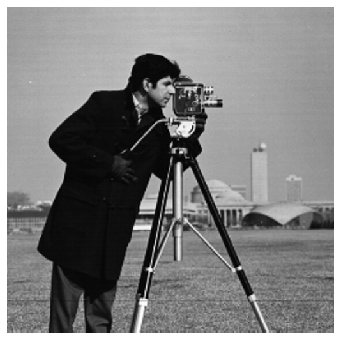

In [22]:
from skimage import data

cameraman = np.array(data.camera(), dtype=np.float32)
cameraman -= 128 # Normalize the pixel values.
plt.figure(figsize=(6, 6))
plt.imshow(cameraman, cmap='gray', interpolation='nearest')
plt.axis('off')

To perform the change of basis $\alpha = \Phi w$, we will use a [two-dimensional discrete cosine transform](https://en.wikipedia.org/wiki/Discrete_cosine_transform#M-D_DCT-II) on non-overlapping $8 \times 8$ blocks of the target image. An implementation of a one-dimensional discrete cosine transform is provided by [scipy.fft](https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html) package. In the below code, we implement two-dimensional discrete cosine transforms and display the $64$ basis vectors as $8\times 8$ images.

In [23]:
from scipy.fft import dct, idct

def dct2(block):
  return dct(dct(block, axis=0, norm='ortho'), axis=1, norm='ortho')

def idct2(block):
  return idct(idct(block, axis=1, norm='ortho'), axis=0, norm='ortho')

Is Phi orthonormal: True


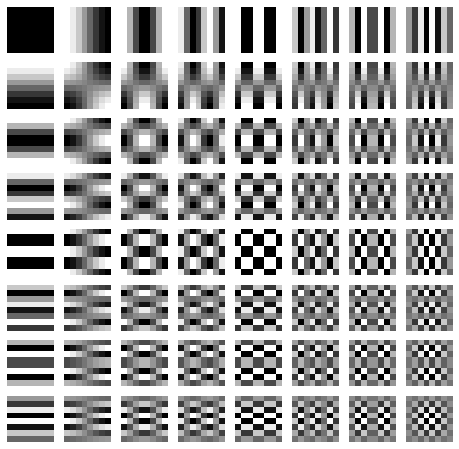

In [24]:
I = np.identity(64)
fig, ax = plt.subplots(8, 8)
fig.set_size_inches(8,8)
Phi = np.zeros((64, 64)) # A linear map implemented by dct2.
for i in range(8):
  for j in range(8):
    block = I[:,8*i+j].reshape(8, 8)
    Phi[:,8*i+j] = idct2(block).reshape(-1)
    ax[i,j].imshow(Phi[:, 8*i+j].reshape(8,8), cmap='gray')
    ax[i,j].axis('off')

print("Is Phi orthonormal:", np.allclose(Phi.T @ Phi, np.identity(64)) \
                             and np.allclose(Phi @ Phi.T, np.identity(64)))

Notice that the displayed basis vectors increase horizontal frequencies as we move to the right in the horizontal direction. Likewise, it increases the vertical frequencies as we move in the vertical direction downwards. Thus, the upper-left basis vectors represent low-frequency parts of the image, while the lower-right basis vectors would be used to represent high-frequency components of the image. <font color='green'>**As the real-world images are structured, we expect that most parts of the image can be expressed by primarily relying on the low-frequency basis vectors, thus resulting in sparse representations.**</font> In contrast, note that we would not expect an unstructured image comprised of completely random pixels to admit a sparse representation in the above basis.

We now implement code that slides along non-overlapping $8 \times 8$ blocks of a target image and applies a discrete cosine transform to each of the blocks. We observe that the transformed cameraman image admits an approximately sparse representation in the transformed coordinate system.

In [25]:
def transform_image(image, transformation):
  # For simplicity assume that the image dimensions are divisible by 8.
  assert image.shape[0] % 8 == 0
  assert image.shape[1] % 8 == 0
  assert len(image.shape) == 2

  transformed_image = np.zeros_like(image, dtype=np.float32)
  for i in range(image.shape[0]//8):
    for j in range(image.shape[1]//8):
      block = image[8*i:8*(i+1), 8*j:8*(j+1)]   
      transformed_block = transformation(block)
      transformed_image[8*i:8*(i+1), 8*j:8*(j+1)] = transformed_block
  return transformed_image


Original image:


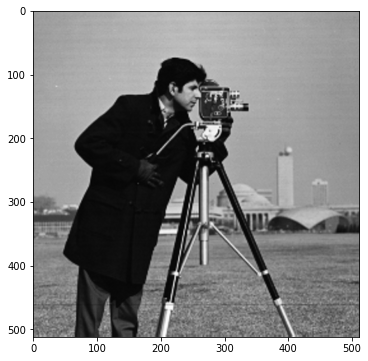

Absolue values of coefficients of transformed image:


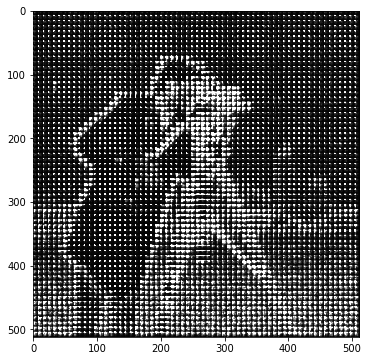

Reconstructed image:


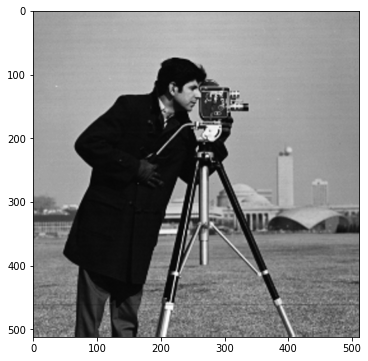

In [26]:
print("Original image:")
plt.figure(figsize=(6,6))
plt.imshow(cameraman, cmap='gray')
plt.show()

print("Absolue values of coefficients of transformed image:")
plt.figure(figsize=(6,6))
encoded_cameraman = transform_image(cameraman, dct2)
sorted_coefficients = np.sort(np.abs(encoded_cameraman.flatten()))
# Set maximum size to display as white color.
vmax = sorted_coefficients[-int(len(sorted_coefficients)*0.075)]
plt.imshow(np.abs(encoded_cameraman), cmap='gray', vmax = vmax, vmin = 0)
plt.show()

print("Reconstructed image:")
plt.figure(figsize=(6,6))
plt.imshow(transform_image(encoded_cameraman, idct2), cmap='gray')
plt.show()

A typical compression scheme would *quantize* the `encoded_cameraman` variable by setting small coefficients to $0$ (there are smarter ways to do it by also taking into account whether the given coefficient represents a high-frequency or low-frequency basis vector; we may want to be more inclined to quantize high-frequency components. See the wikipedia page on [JPEG compression](https://en.wikipedia.org/wiki/JPEG#JPEG_compression)). Let us now try a simple quantizing scheme that simply keeps a given fraction `p` of coefficients largest in absolute value.

In [27]:
def quantize_coefficients(transformed_image, p):
  """ :transformed_image: An image represented in the transformed basis.
      :p: A fraction of largest coefficients to keep.
      :returns: A quantized image, retaining p-fraction of the largest
        coefficients in absolute value.
  """
  sorted = np.sort(np.abs(transformed_image).flatten())
  threshold = sorted[-int(len(sorted)*p)]
  quantized_image = np.copy(transformed_image)
  quantized_image[np.abs(quantized_image) < threshold] = 0
  return quantized_image

Original image:


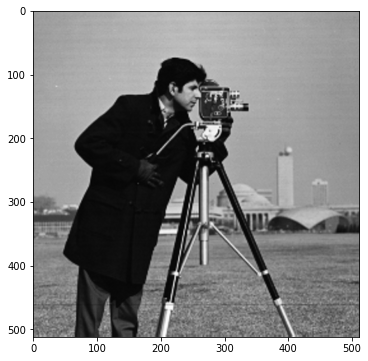

Absolue values of coefficients of transformed image:


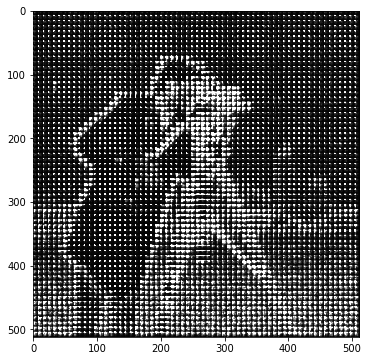

Quantized image at level p= 0.025


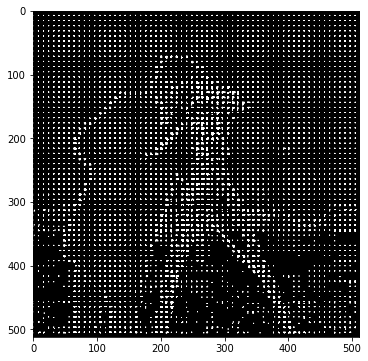

Reconstruction from the quantized image:


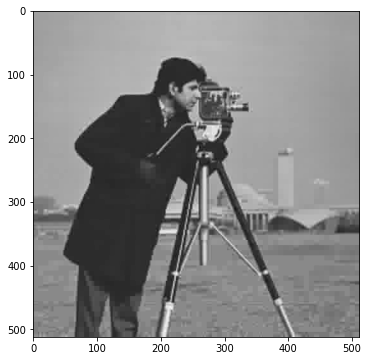

Average l_2 squared reconstruction error: 59.32952


In [28]:
print("Original image:")
plt.figure(figsize=(6,6))
plt.imshow(cameraman, cmap='gray')
plt.show()

print("Absolue values of coefficients of transformed image:")
plt.figure(figsize=(6,6))
encoded_cameraman = transform_image(cameraman, dct2)
sorted_coefficients = np.sort(np.abs(encoded_cameraman.flatten()))
# Set maximum size to display as white color.
vmax = sorted_coefficients[-int(len(sorted_coefficients)*0.075)]
plt.imshow(np.abs(encoded_cameraman), cmap='gray', vmax = vmax, vmin = 0)
plt.show()

p = 0.025 # The fraction of coefficients to keep.
print("Quantized image at level p=",p)
quantized_image = quantize_coefficients(encoded_cameraman, p)
plt.figure(figsize=(6,6))
plt.imshow(np.abs(quantized_image), cmap='gray', vmax=vmax, vmin=0)
plt.show()

print("Reconstruction from the quantized image:")
plt.figure(figsize=(6,6))
reconstructed_image = transform_image(quantized_image, idct2)
plt.imshow(reconstructed_image, cmap='gray')
plt.show()

print("Average l_2 squared reconstruction error:",
      np.average((cameraman.flatten() - reconstructed_image.flatten())**2))

In the next exercise, you are asked to implement a single-pixel camera.

### Exercise 3

- Complete the single-pixel camera implementation in the below cell.
- How many measurements need to be taken to recover a "visually acceptable" `cameraman` image? How does the number of measurements compare with the number of pixels in the image?

In [29]:
class SinglePixelCamera(object):
  """ An implementation of a single pixed camera. """


  def __init__(self, d1, d2):
    """ :(d1, d2): Shape of the image. """
    self.d1 = d1
    self.d2 = d2


  def get_mirror_positions(self, n_measurements):
    """ Returns a numpy array of shape (n_measuremes, self.d1 * self.d2), whose
    i-th row stores {-1, +1}-valued mirror positions to be used for the
    i-th linear measurement.
    """
    ############################################################################
    # Complete the below implementation.
    # Sample mirror positions as i.i.d. Rademacher random variables.
    return np.random.binomial(n=1, p=0.5,
                              size=(n_measurements, self.d1*self.d2))*2.0 - 1.0
    ############################################################################


  def take_measurements(self, X, w_star):
    """ :X: A measurement matrix of shape (n, d1*d2).
        :w_star: The signal vector (represented as a 2d-array) that we are
          trying to measure.
        :returns: A vector of linear measurements of (an appropriately
          flattened) image w_star.
    """
    ############################################################################
    # Complete the below implementation.

    # First, we flatten the image array w_star by flattening each 8 x 8 block.
    print("Started taking measurements")
    flattened_image = np.zeros(self.d1 * self.d2)
    offset = 0
    for i in range(self.d1//8):
      for j in range(self.d2//8):
        block = w_star[8*i:8*(i+1), 8*j:8*(j+1)]   
        flattened_image[offset:offset+64] = block.flatten()
        offset += 64

    # We can now compute the linear measurements.
    flattened_image.reshape(-1,1) 
    y = X @ flattened_image
    return y
    ############################################################################


  def reconstruct_signal(self, X, y):
    """ :X: An n \times d measurements matrix.
        :y: An n \times 1 vector of observations.
        :returns: A vector w that should approximately recover the true signal
          w_star.
    """
    ############################################################################
    # Complete the below implementation.

    # Transform X to X @ Phi (note that Phi=block-diagonal[Phi, Phi, ..., Phi]).
    blocks = []
    for block_id in range(X.shape[1]//64):
      blocks.append(X[:,block_id*64:(block_id+1)*64] @ Phi)
    transformed_X = np.concatenate(blocks, axis=1)
    transformed_X /= np.sqrt(transformed_X.shape[0]) # For numeric stability.
    y /= np.sqrt(transformed_X.shape[0]) # Now we also need to rescale y.

    # Apply the basis pursuit solver in the transformed coordinate system.
    print("Starting signal reconstruction.")
    alpha = compute_minimum_l1_norm_solution(transformed_X, y)

    # Now we need to transform alpha into the original coordinate system
    # and reshape the image into an array of shape (self.d1, self.d2).
    reconstructed_image = np.zeros((self.d1, self.d2))
    offset = 0
    for i in range(self.d1//8):
      for j in range(self.d2//8):
        alpha_block = alpha[offset:offset+64]
        transformed_block = (Phi @ alpha_block).reshape(8, 8)
        reconstructed_image[8*i:8*(i+1), 8*j:8*(j+1)] = transformed_block
        offset += 64

    return reconstructed_image
    ############################################################################


  def take_picture(self, n_measurements, w_star):
    """ :n_measurements: The number of measurements y_i = <x_i, w*> to take.
        :w_star: The signal vector passed as a two-dimensional image.
        :returns: A picture represented in the standard basis, returned as a
          two-dimensional array.
    """
    X = self.get_mirror_positions(n_measurements)
    y = self.take_measurements(X, w_star)
    return self.reconstruct_signal(X, y)


Original image:


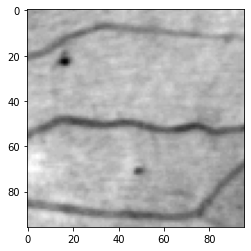

Number of pixels: 9216
Number of measurements: 2304
Reconstructed image:
Started taking measurements
Starting signal reconstruction.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  3e+06  4e+04  1e-16  1e+00
 1:  8.0338e+04  8.0349e+04  1e+06  2e+04  7e-16  1e+01
 2:  1.0488e+05  1.0489e+05  8e+05  1e+04  6e-16  1e+01
 3:  1.1135e+05  1.1136e+05  2e+05  3e+03  6e-16  1e+01
 4:  1.1727e+05  1.1728e+05  1e+05  2e+03  4e-16  6e+00
 5:  1.2184e+05  1.2185e+05  6e+04  9e+02  5e-16  3e+00
 6:  1.2485e+05  1.2485e+05  3e+04  4e+02  6e-16  1e+00
 7:  1.2638e+05  1.2638e+05  1e+04  2e+02  7e-16  6e-01
 8:  1.2713e+05  1.2713e+05  5e+03  8e+01  9e-16  3e-01
 9:  1.2748e+05  1.2748e+05  2e+03  4e+01  9e-16  1e-01
10:  1.2763e+05  1.2763e+05  1e+03  2e+01  9e-16  6e-02
11:  1.2770e+05  1.2770e+05  5e+02  7e+00  1e-15  3e-02
12:  1.2774e+05  1.2774e+05  2e+02  3e+00  2e-15  1e-02
13:  1.2775e+05  1.2775e+05  9e+01  1e+00  2e-15  5e-03
14:  1.2776e+05  1.2776e+05  

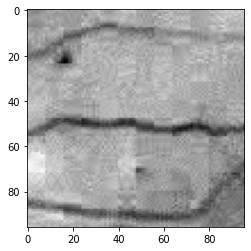

In [30]:
%%time

# Let us test our implementation.
# The cameraman image that we have used below is too big for the purpose of 
# testing out the implementation of single-pixel camera.
# Instead, we will switch to a data.microaneurysms() image (which is approximately
# 25 times smaller in size).
#
# WARNING: this can take few couple minutes to execute even for this relatively
# small problem. The reason for slow reconstruction is because we are using a
# general-purpose solver for our l1 minimization problem. Specialized solvers
# can achieve much faster performance.

test_image = np.array(data.microaneurysms(), dtype=np.float32)
test_image = test_image[:96, :96] # Make dimensions divisible by 8.
plt.imshow(test_image, cmap='gray')

height = test_image.shape[0]
width = test_image.shape[1]
camera = SinglePixelCamera(height, width)
print("Original image:")
plt.imshow(test_image, cmap='gray')
plt.show()

print("Number of pixels:", height*width)
n_measurements = (height*width)//4
print("Number of measurements:", n_measurements)
print("Reconstructed image:")
picture = camera.take_picture(n_measurements, test_image)
plt.imshow(picture, cmap='gray')
print("Average l2 reconstruction error:",
      np.average((test_image - picture)**2))

#### Solution

A possible implementation is provided below.

```
class SinglePixelCamera(object):
  """ An implementation of a single pixed camera. """


  def __init__(self, d1, d2):
    """ :(d1, d2): Shape of the image. """
    self.d1 = d1
    self.d2 = d2


  def get_mirror_positions(self, n_measurements):
    """ Returns a numpy array of shape (n_measuremes, self.d1 * self.d2), whose
    i-th row stores {-1, +1}-valued mirror positions to be used for the
    i-th linear measurement.
    """
    ############################################################################
    # Complete the below implementation.
    # Sample mirror positions as i.i.d. Rademacher random variables.
    return np.random.binomial(n=1, p=0.5,
                              size=(n_measurements, self.d1*self.d2))*2.0 - 1.0
    ############################################################################


  def take_measurements(self, X, w_star):
    """ :X: A measurement matrix of shape (n, d1*d2).
        :w_star: The signal vector (represented as a 2d-array) that we are
          trying to measure.
        :returns: A vector of linear measurements of (an appropriately
          flattened) image w_star.
    """
    ############################################################################
    # Complete the below implementation.

    # First, we flatten the image array w_star by flattening each 8 x 8 block.
    print("Started taking measurements")
    flattened_image = np.zeros(self.d1 * self.d2)
    offset = 0
    for i in range(self.d1//8):
      for j in range(self.d2//8):
        block = w_star[8*i:8*(i+1), 8*j:8*(j+1)]   
        flattened_image[offset:offset+64] = block.flatten()
        offset += 64

    # We can now compute the linear measurements.
    flattened_image.reshape(-1,1) 
    y = X @ flattened_image
    return y
    ############################################################################


  def reconstruct_signal(self, X, y):
    """ :X: An n \times d measurements matrix.
        :y: An n \times 1 vector of observations.
        :returns: A vector w that should approximately recover the true signal
          w_star.
    """
    ############################################################################
    # Complete the below implementation.

    # Transform X to X @ Phi (note that Phi=block-diagonal[Phi, Phi, ..., Phi]).
    blocks = []
    for block_id in range(X.shape[1]//64):
      blocks.append(X[:,block_id*64:(block_id+1)*64] @ Phi)
    transformed_X = np.concatenate(blocks, axis=1)
    transformed_X /= np.sqrt(transformed_X.shape[0]) # For numeric stability.
    y /= np.sqrt(transformed_X.shape[0]) # Now we also need to rescale y.

    # Apply the basis pursuit solver in the transformed coordinate system.
    print("Starting signal reconstruction.")
    alpha = compute_minimum_l1_norm_solution(transformed_X, y)

    # Now we need to transform alpha into the original coordinate system
    # and reshape the image into an array of shape (self.d1, self.d2).
    reconstructed_image = np.zeros((self.d1, self.d2))
    offset = 0
    for i in range(self.d1//8):
      for j in range(self.d2//8):
        alpha_block = alpha[offset:offset+64]
        transformed_block = (Phi @ alpha_block).reshape(8, 8)
        reconstructed_image[8*i:8*(i+1), 8*j:8*(j+1)] = transformed_block
        offset += 64

    return reconstructed_image
    ############################################################################


  def take_picture(self, n_measurements, w_star):
    """ :n_measurements: The number of measurements y_i = <x_i, w*> to take.
        :w_star: The signal vector passed as a two-dimensional image.
        :returns: A picture represented in the standard basis, returned as a
          two-dimensional array.
    """
    X = self.get_mirror_positions(n_measurements)
    y = self.take_measurements(X, w_star)
    return self.reconstruct_signal(X, y)

```

## Bibliographic Remarks

The basis pursuit linear program is attributed to the seminal work of *Chen, Donoho, and Saunders [1998]*, with the closely related lasso program introduced in the statistics literature by *Tibshirani [1996]*. The theoretical foundations of compressed sensing, provably demonstrating that sparse signals can be recovered from underdetermined linear systems, were laid down in the pioneering works of *Candes and Tao [2005]*, *Donoho [2006]* and
*Candès, Romberg, and Tao [2006]*. The proof that RIP implies RNP presented in this practical session was taken from the paper by *Candes [2008]* and Proposition 7.11 in the textbook by *Wainwright [2019]*. The idea of single-pixel cameras was introduced by *Duarte, Davenport, Takhar, Laska, Sun, Kelly, and Baraniuk [2008]*; for the current state of single-
pixel imaging, see the recent review paper by *Gibson, Johnson, and Padgett [2020]*. One (perhaps surprising) extension of the results presented in this practical session is that access to linear measurements is not necessary to recover the underlying sparse signal. Indeed, linear programming can be used to recover sparse signals from underdetermined systems of signs of linear measurements, as shown in the work of *Plan and Vershynin [2013]*. In this
practical session, we have only glimpsed into the rich theory of compressed sensing and $\ell_{1}$ regularization. The interested reader will find more advanced topics, further discussions and extensive bibliographic details in the textbooks by *Bühlmann and Van De Geer [2011]*,
*Foucart and Rauhut [2013]*, *Hastie, Tibshirani, and Wainwright [2019]* and *Wainwright [2019]*.

**References**

P. Bühlmann and S. Van De Geer. Statistics for high-dimensional data: methods, theory and applications. Springer Science & Business Media, 2011.

E. J. Candes. The restricted isometry property and its implications for compressed sensing. Comptes rendus mathematique, 346(9-10):589–592, 2008.

E. J. Candes and T. Tao. Decoding by linear programming. IEEE transactions on
information theory, 51(12):4203–4215, 2005.

E. J. Candès, J. Romberg, and T. Tao. Robust uncertainty principles: Exact signal reconstruction from highly incomplete frequency information. IEEE Transactions on information theory, 52(2):489–509, 2006.

S. S. Chen, D. L. Donoho, and M. A. Saunders. Atomic decomposition by basis pursuit. SIAM Journal on Scientific Computing, 20(1):33–61, 1998.

D. L. Donoho. Compressed sensing. IEEE Transactions on information theory, 52(4): 1289–1306, 2006.

M. F. Duarte, M. A. Davenport, D. Takhar, J. N. Laska, T. Sun, K. F. Kelly, and
R. G. Baraniuk. Single-pixel imaging via compressive sampling. IEEE signal processing magazine, 25(2):83–91, 2008.

S. Foucart and H. Rauhut. An invitation to compressive sensing. In A mathematical introduction to compressive sensing, pages 1–39. Springer, 2013.

G. M. Gibson, S. D. Johnson, and M. J. Padgett. Single-pixel imaging 12 years on: a review. Optics Express, 28(19):28190–28208, 2020.

T. Hastie, R. Tibshirani, and M. Wainwright. Statistical learning with sparsity: the lasso and generalizations. Chapman and Hall/CRC, 2019.

Y. Plan and R. Vershynin. One-bit compressed sensing by linear programming. Communications on Pure and Applied Mathematics, 66(8):1275–1297, 2013.

R. Tibshirani. Regression shrinkage and selection via the lasso. Journal of the Royal Statistical Society: Series B (Methodological), 58(1):267–288, 1996.

M. J. Wainwright. High-dimensional statistics: A non-asymptotic viewpoint, volume 48. Cambridge University Press, 2019.